In [2]:
import sys
import os
# Add the path where functions.py is located
sys.path.append('/home/jiguo/denovo_rpe1_scrnaseq/analysis_pipeline')
import functions as fn
import pandas as pd


In [ ]:
adata = fn.load_adata('')

AnnData object with n_obs × n_vars = 12572 × 11428
    obs: 'condition', 'replicate', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'n_genes', 'S_score', 'G2M_score', 'phase'
    var: 'ensembl_gene_id', 'gene_name', 'in_jakobsen', 'mito', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'mean', 'std'
    uns: 'log1p'
    layers: 'counts', 'log', 'normalised', 'regress_cc'

In [4]:
def calculate_correlation_matrix(adata):
    df = pd.DataFrame(adata.X, columns=adata.var_names)
    return df.corr(method='pearson')

In [5]:
corr_control = pd.read_csv('/home/jiguo/output/correlation/corr_control.csv', index_col=0)
corr_centrinone = pd.read_csv('/home/jiguo/output/correlation/corr_centrinone.csv', index_col=0)
corr_wo2h = pd.read_csv('/home/jiguo/output/correlation/corr_wo2h.csv', index_col=0)

In [6]:
def calculate_coexpression_change(corr_1, corr_2):
    coexpression_change = corr_2 - corr_1
    return coexpression_change

> Load list

In [17]:
list_Cp = pd.read_csv("/home/jiguo/denovo_rpe1_scrnaseq/genelist_C.txt")['gene_names'].tolist()
list_C = pd.read_csv("/home/jiguo/denovo_rpe1_scrnaseq/gene_with_GO_terms_related_with_CentrosomeBiosynthesis.txt")['gene_names'].tolist()
list_A = pd.read_csv("/home/jiguo/denovo_rpe1_scrnaseq/Genes_with_GO_terms_RNA-metabolic-process - select.csv")["Gene names"].tolist()
de_genes = pd.read_csv('/home/jiguo/denovo_rpe1_scrnaseq/de_genes.csv')
wo2h_genes = de_genes[
    (de_genes['Conditions']=='wo-2h')
]['Gene_name'].tolist()

In [ ]:
def chck_genes_in_adata(gene_list, adata):
    if gene in gene_list:
        adata.var_names = adata.var_names.tolist()
        if gene in adata.var_names:
            return True
        else:
            gene_list.remove(gene)
    return gene_list

In [29]:
def plot_correlation_heatmap(corr_matrix, gene_list1, gene_list2):
    idx_1 = [np.where(corr_matrix.index == g)[0][0] for g in gene_list1]
    idx_2 = [np.where(corr_matrix.columns == g)[0][0] for g in gene_list2]
    sub_corr_matrix = corr_matrix.iloc[idx_1, idx_2]
    sns.clustermap(sub_corr_matrix, cmap='coolwarm',
                   figsize=(16, 10), vmin=-0.8, vmax=1)
    plt.title(f'correlation heatmap for {len(gene_list1)} genes vs {len(gene_list2)} genes')
    plt.show()

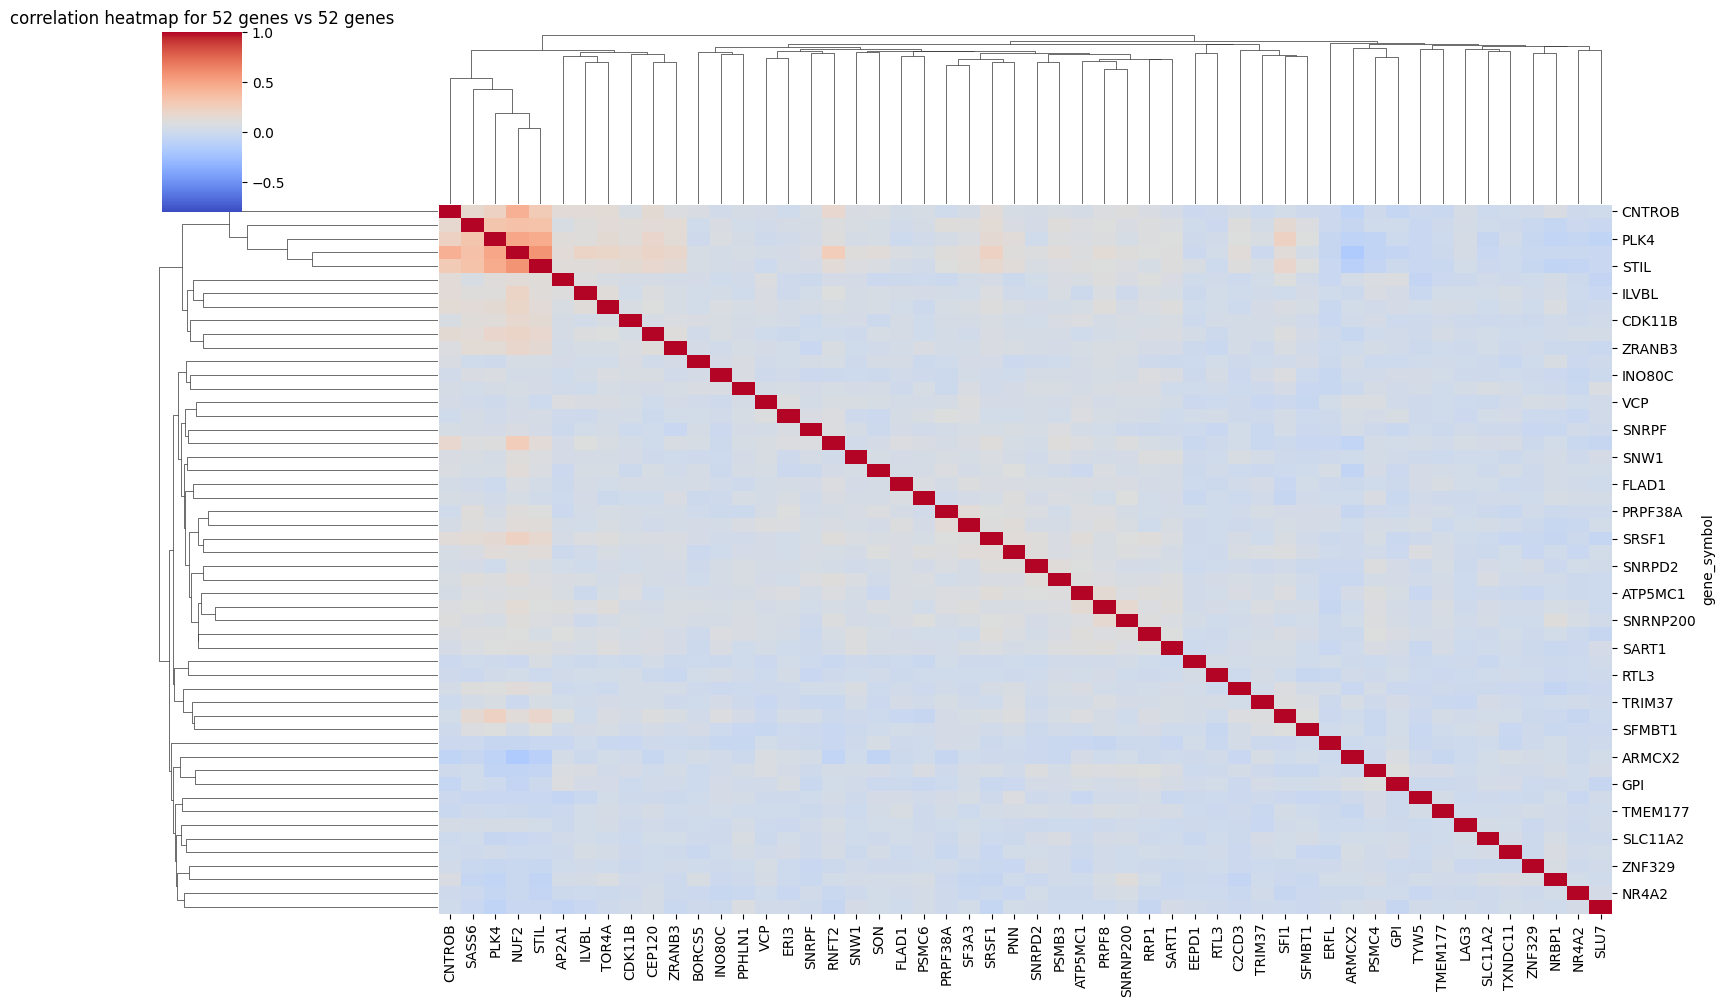

In [30]:
plot_correlation_heatmap(corr_wo2h, list_Cp, list_Cp)

In [69]:
# Get indices for list_C and wo2h_genes in the coexpression_change matrix
idx_C = [np.where(coexpression_change.index == g)[0][0] for g in list_C]
idx_de = [np.where(coexpression_change.index == g)[0][0] for g in wo2h_genes]
# Create a new DataFrame for the coexpression change matrix
coexpression_change_subset = coexpression_change.iloc[idx_C, idx_de]
# Plot correlation change matrix
sns.clustermap(
    coexpression_change_subset,
    cmap='coolwarm',
    center=0,
    vmin=-0.5,
    vmax=0.5,
)
plt.title('Coexpression change between Centrosome Biosynthesis genes and DE genes in centrinone vs control')
plt.tight_layout()
plt.show()

NameError: name 'coexpression_change' is not defined

In [ ]:
de_wo2h_mask = adata.var_names.isin(wo2h_genes)
de_wo2h_adata = adata[:, de_wo2h_mask].copy()
c_mask = adata.var_names.isin(list_C)
c_adata = adata[:, c_mask].copy()
# remove the missing genes in list C


In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sc.pl.scatter(control, x=genes[0], y=genes[1], ax=ax[0], show=False, title='Control')
sc.pl.scatter(centrinone, x=genes[0], y=genes[1], ax=ax[1], show=False, title='Centrinone')

### Bulk

### Genearate Pseudobulk data from original anndata object

In [ ]:
adata = sc.read_h5ad('/home/jiguo/data/data/anndata/adata_all_pp_cc.h5')
adata.obs['sample'] = (
		adata.obs['condition'].astype(str) + '_' +
		adata.obs['replicate'].astype(str)
)

In [3]:
pseudobulk_counts = pd.DataFrame(
		columns = adata.var_names,
		index = adata.obs['sample'].unique()
)
for sample in pseudobulk_counts.index:
    # Get cell indices for this sample
    sample_mask = adata.obs['sample'] == sample
    sample_counts = adata.layers['counts'][sample_mask].sum(axis=0)
    pseudobulk_counts.loc[sample] = sample_counts.A1


In [4]:
pseudobulk_meta = adata.obs[
		['condition', 'replicate', 'sample']
].drop_duplicates().set_index('sample')
pseudobulk_adata = sc.AnnData(
    X=sparse.csr_matrix(pseudobulk_counts.fillna(0)),
    obs=pseudobulk_meta,
    var=adata.var
)

In [ ]:
sc.pp.normalize_total(pseudobulk_adata, target_sum=1e6)  # CPM normalization
sc.pp.log1p(pseudobulk_adata)  # Log transform

In [ ]:
# de_wo2h_mask = pseudobulk_adata.var_names.isin(wo2h_genes)
# de_wo2h_adata = pseudobulk_adata[:, de_wo2h_mask].copy()

### Study the correlation between the expression level of DE genes and Genes related to RNA metabolism

In [7]:
pseudobulk_adata

AnnData object with n_obs × n_vars = 12 × 11428
    obs: 'condition', 'replicate'
    var: 'ensembl_gene_id', 'gene_name', 'in_jakobsen', 'mito', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'mean', 'std'
    uns: 'log1p'

In [17]:
list_C = pd.read_csv("/home/jiguo/denovo_rpe1_scrnaseq/genelist_C.txt")['gene_names'].tolist()
list_A = pd.read_csv("/home/jiguo/denovo_rpe1_scrnaseq/Genes_with_GO_terms_RNA-metabolic-process - select.csv")["Gene names"].tolist()
de_genes = pd.read_csv('/home/jiguo/denovo_rpe1_scrnaseq/de_genes.csv')
wo2h_genes = de_genes[
    (de_genes['Conditions']=='wo-2h')
]['Gene_name'].tolist()
de_wo2h_mask = pseudobulk_adata.var_names.isin(wo2h_genes)
de_wo2h_adata = pseudobulk_adata[:, de_wo2h_mask].copy()
c_mask = pseudobulk_adata.var_names.isin(list_C)
c_adata = pseudobulk_adata[:, c_mask].copy()
# remove the missing genes in list C
for gene in list_C:
    if gene not in pseudobulk_adata.var_names:
        print(f"Gene {gene} not found in adata.")
        list_C.remove(gene)
for gene in wo2h_genes:
    if gene not in pseudobulk_adata.var_names:
        print(f"Gene {gene} not found in adata.")
        wo2h_genes.remove(gene)
len(list_C)

Gene HNRPA1 not found in adata.
Gene U2AFBP not found in adata.
Gene NPIPL3 not found in adata.
Gene LOC340074 not found in adata.
Gene SBSPON not found in adata.
Gene VWC2L not found in adata.
Gene PCDHGB4 not found in adata.
Gene CREF not found in adata.
Gene MGC23284 not found in adata.
Gene LILRA5 not found in adata.
Gene HBM not found in adata.
Gene PCDH11X not found in adata.
Gene F7 not found in adata.
Gene ANKS5A not found in adata.
Gene CASKIN1 not found in adata.
Gene ZIP12 not found in adata.
Gene HIP6 not found in adata.


59

In [12]:
# only keep the data in the condition of interest
def filter_condition(adata, condition, condition2='control'):
    mask = adata.obs['condition'].isin([condition, condition2])
    return adata[mask].copy()

wo_2h_adata = filter_condition(pseudobulk_adata, 'wo-2h')
wo_2h_adata

AnnData object with n_obs × n_vars = 6 × 11428
    obs: 'condition', 'replicate'
    var: 'ensembl_gene_id', 'gene_name', 'in_jakobsen', 'mito', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'mean', 'std'
    uns: 'log1p'

In [13]:
def plot_correlation(pseudobulk_adata, control_condition, ):
    return 0

In [18]:
missing_in_C = [g for g in list_C if g not in subset.var_names]
missing_in_de = [g for g in wo2h_genes if g not in subset.var_names]

if missing_in_C:
    print(f"Genes from list_C not found in subset: {missing_in_C}")
    list_C = [g for g in list_C if g in subset.var_names]

if missing_in_de:
    print(f"Genes from wo2h_genes not found in subset: {missing_in_de}")
    wo2h_genes = [g for g in wo2h_genes if g in subset.var_names]

Genes from list_C not found in subset: ['GOLGA6L1', 'RIMBP3', 'LOC100287343', 'RASAL3', 'CAGH4', 'EFCAB4A', 'SPANXN3']


In [1]:
# Subset the AnnData to ONLY the union of genes (DE+List = DE+List genes)
genes_union = list(set(list_C) | set(wo2h_genes))
subset = wo_2h_adata[:, wo_2h_adata.var_names.isin(genes_union)]
# Convert sparse data to dense array (if needed)
X = subset.X.toarray() if hasattr(subset.X, 'toarray') else subset.X
# Get indices for list_C and wo2h_genes in the subset matrix
idx_C = [np.where(subset.var_names == g)[0][0] for g in list_C]
idx_de = [np.where(subset.var_names == g)[0][0] for g in wo2h_genes]
# Compute full correlation matrix (genes x genes)
corr_all = np.corrcoef(X.T)  # Shape: (DE+List, DE+List)
corr_block = corr_all[np.ix_(idx_C, idx_de)]
# Build DataFrame for plotting
correlations = pd.DataFrame(
    corr_block,
    index=list_C,
    columns=wo2h_genes
)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.clustermap(
    correlations,
    cmap='coolwarm',
    center=0,
    fmt=".2f",)
plt.title('Correlation between Centrosome Biosynthesis genes and DE genes in wo-2h')
plt.tight_layout()
plt.show()

NameError: name 'list_C' is not defined